In [62]:
!wget https://raw.githubusercontent.com/Dewasurya16/Dataset-Sentiment-/main/Dataset%20Instagram%20Sentiment%20-%20dataset_komentar_instagram_cyberbullying.csv

--2022-12-15 16:04:02--  https://raw.githubusercontent.com/Dewasurya16/Dataset-Sentiment-/main/Dataset%20Instagram%20Sentiment%20-%20dataset_komentar_instagram_cyberbullying.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61160 (60K) [text/plain]
Saving to: ‘Dataset Instagram Sentiment - dataset_komentar_instagram_cyberbullying.csv.2’

Dataset Instagram S 100%[===================>]  59.73K  --.-KB/s    in 0.001s  

2022-12-15 16:04:03 (42.8 MB/s) - ‘Dataset Instagram Sentiment - dataset_komentar_instagram_cyberbullying.csv.2’ saved [61160/61160]



In [63]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import sklearn
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation
from joblib import load

%matplotlib inline

In [65]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
data = pd.read_csv('/content/Dataset Instagram Sentiment - dataset_komentar_instagram_cyberbullying.csv')
data.head()

,Sentiment,text
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegugu...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  400 non-null    int64 
 1   text       400 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


In [68]:
print('Total Jumlah Teks :', data.shape[0], 'data\n')
print('terdiri dari (Sentiment):')
print('-- [0] Sentiment Positive\t:', data[data.Sentiment == 1].shape[0], 'data')
print('-- [1] Sentiment Negative\t:', data[data.Sentiment == 0].shape[0], 'data')

Total Jumlah Teks : 400 data

terdiri dari (Sentiment):
-- [0] Sentiment Positive	: 200 data
-- [1] Sentiment Negative	: 200 data


0    200
1    200
Name: Sentiment, dtype: int64


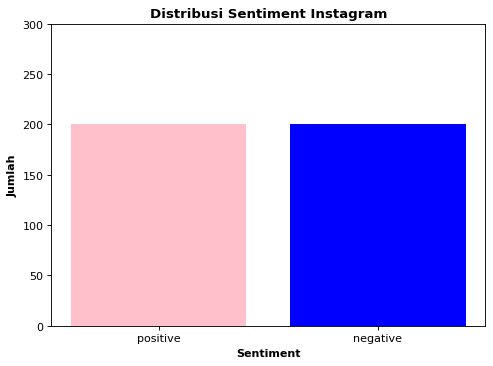

In [69]:
height = data['Sentiment'].value_counts()
labels = ('positive', 'negative')
y_pos = np.arange(len(labels))
print(height)
plt.figure(figsize=(7,5), dpi=80)
plt.ylim(0,300)
plt.title('Distribusi Sentiment Instagram', fontweight='bold')
plt.xlabel('Sentiment', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['pink', 'Blue'])
plt.xticks(y_pos, labels)
plt.show()

# **Teks** **Preprocessing**

In [70]:
def text_preprocessing(text):
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [71]:
raw_sample = data['text'].iloc[20]
case_folding = text_preprocessing(raw_sample)

print('Raw data\t: ', raw_sample)
print('\nCase folding\t: ', case_folding)

Raw data	:  Kasian ih nyari uang sampe segitunya

Case folding	:  Kasian ih nyari uang sampe segitunya


World Normalization

In [72]:
key_norm = pd.read_csv('https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv')
print(key_norm.head(10))

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi
5    6         acra       acara
6    7       acrany    acaranya
7    8       acrnya    acaranya
8    9       action        aksi
9   10       active       aktif


(3720, 3)

In [73]:
def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
    text = str.lower(text)
    return text

Filtering

In [74]:
stopwords_ind = stopwords.words('indonesian')

In [75]:
len(stopwords_ind)

758

In [76]:
stopwords_ind[:10]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir']

In [77]:
more_stopword = ['cinta', ' capres']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)

In [78]:

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
    text = stemmer.stem(text)
    return text

In [79]:
raw_sample = data['text'].iloc[56]
case_folding = text_preprocessing(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:   <USERNAME> itu yg komen via nyinyir mulu duh kyak dia gak pernah nyinyirin orang aja, mungkin lebih parah, kalo org sudah sok bener mah gitu, pdhal ini kan media sosial, hak dia dong instagram juga instagram dia, yg penting kan nyinyir gak pake ig s
Case folding		:  USERNAME itu yg komen via nyinyir mulu duh kyak dia gak pernah nyinyirin orang aja mungkin lebih parah kalo org sudah sok bener mah gitu pdhal ini kan media sosial hak dia dong instagram juga instagram dia yg penting kan nyinyir gak pake ig s
Stopword removal	:  USERNAME yg komen via nyinyir mulu duh kyak gak nyinyirin orang aja parah kalo org sok bener mah gitu pdhal media sosial hak instagram instagram yg nyinyir gak pake ig s
Stemming		:  username yg komen via nyinyir mulu duh kyak gak nyinyirin orang aja parah kalo org sok bener mah gitu pdhal media sosial hak instagram instagram yg nyinyir gak pake ig s


In [80]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
    text = text_preprocessing(text)
    text = text_normalize(text)
    text = remove_stop_words(text)
    text = stemming(text)
    return text

In [81]:
%time data['clean'] = data['text'].apply(text_preprocessing_process)
data['clean'] = data["clean"].astype(str).str.lower()

CPU times: user 4min 31s, sys: 1.01 s, total: 4min 32s
Wall time: 5min 2s


In [82]:
data

,Sentiment,text,clean
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegugu...,username tolol gak hubung nya gugur pakai hija...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek tatacowo banget bain balikanhadewwntar ...
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn mewek skr lengket duhhh labil banget sih ...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesel att nya anak kasi kembang psikis an...
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lgsakit jiwaknp peran utama...
...,...,...,...
395,1,Bangga sama suami yg selalu ingat istri disela...,bangga suami istri sela apa profesi kau juara ...
396,1,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun kerja halal tuk nafkah keluarga semangat
397,1,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayoritas pegangguran kerja putus asaa t...
398,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...,username asli cantik ayu loh mbak temu langsun...


In [83]:
data.to_csv('data_clean.csv') # Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)


# Feature Engginering

In [84]:
# Pisahkan kolom fitur dan target
X = data['clean']
y = data['Sentiment']

In [85]:
X

0      username tolol gak hubung nya gugur pakai hija...
1      geblek tatacowo banget bain balikanhadewwntar ...
2      kmrn mewek skr lengket duhhh labil banget sih ...
3      inti kesel att nya anak kasi kembang psikis an...
4      hadewwwww permpuan lgsakit jiwaknp peran utama...
                             ...                        
395    bangga suami istri sela apa profesi kau juara ...
396      apaoun kerja halal tuk nafkah keluarga semangat
397    gojek mayoritas pegangguran kerja putus asaa t...
398    username asli cantik ayu loh mbak temu langsun...
399    username suami umur mbak tua alhamdulillah sua...
Name: clean, Length: 400, dtype: object

In [86]:
y

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: Sentiment, Length: 400, dtype: int64

# **Feature Extraxction TF-IDF**

In [87]:
tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [88]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

2404


In [89]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


In [90]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abiss,abu,ac,...,yoo,you,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.247458,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

# **Feature Selection**

In [93]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [94]:
# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=700) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1])

Original feature number: 2404
Reduced feature number: 700


In [95]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.711750
1,0.266795
2,0.985369
3,0.001097
4,0.488093
...,...
2399,0.207445
2400,0.176714
2401,0.226659
2402,0.326587


In [96]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.711750,aamiin
1,0.266795,aammiinnn
2,0.985369,abal
3,0.001097,abang
4,0.488093,abbey
...,...,...
2399,0.207445,yutub
2400,0.176714,zaman
2401,0.226659,zholimi
2402,0.326587,zina


In [97]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
447,7.467661,cantik
1442,5.067993,moga
379,4.658385,bodoh
1126,4.268218,keren
1049,4.221197,kampung
...,...,...
872,0.000014,hitam
5,0.000008,abege
489,0.000004,cma
626,0.000003,duit


In [98]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([ True, False,  True, ..., False, False, False])

In [99]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
    if bool:
        new_feature.append(f)
    selected_feature = new_feature

selected_feature

['aamiin',
 'abal',
 'abbey',
 'adat',
 'agus',
 'ah',
 'ajaaa',
 'akhlak',
 'akun',
 'akuuu',
 'alami',
 'alesha',
 'alhamdulillah',
 'allah',
 'allahaamiin',
 'am',
 'ama',
 'amiiii',
 'amiin',
 'amin',
 'amit',
 'amora',
 'ampuuunmalu',
 'an',
 'anang',
 'angguunn',
 'ani',
 'anjing',
 'anjir',
 'anjirrrr',
 'antem',
 'anti',
 'anyiennnnggg',
 'apain',
 'apaoun',
 'apik',
 'ariel',
 'artis',
 'ashanti',
 'asik',
 'ato',
 'att',
 'audisi',
 'aurel',
 'awat',
 'awet',
 'ayah',
 'ayu',
 'azriel',
 'babang',
 'babi',
 'babiii',
 'baca',
 'bacot',
 'badaaiik',
 'baguass',
 'bagus',
 'bagussss',
 'bahagia',
 'baik',
 'bak',
 'bakat',
 'bala',
 'balajaer',
 'balas',
 'banci',
 'bang',
 'bangeeet',
 'bangeg',
 'banget',
 'bangett',
 'bangetttt',
 'bangetttttttt',
 'bangga',
 'bangsa',
 'bangsat',
 'bangt',
 'banyak',
 'barakallah',
 'bawa',
 'bayar',
 'beautiful',
 'becus',
 'bedak',
 'begitu',
 'bego',
 'begoh',
 'begok',
 'belajaer',
 'belepotan',
 'beliau',
 'bella',
 'benci',
 'bencong'

In [100]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
    if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
        kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [101]:
kbest_feature

{'username': 2300,
 'tolol': 2231,
 'gak': 714,
 'nya': 1623,
 'pakai': 1688,
 'hijab': 867,
 'panas': 1696,
 'otak': 1678,
 'sih': 2048,
 'komentar': 1175,
 'banget': 220,
 'tuh': 2246,
 'kmrn': 1165,
 'mbak': 1374,
 'ato': 152,
 'sensasi': 2005,
 'biar': 339,
 'att': 153,
 'orang': 1669,
 'bener': 304,
 'benci': 302,
 'tau': 2173,
 'nama': 1513,
 'manusia': 1341,
 'suka': 2122,
 'haters': 844,
 'permpuan': 1760,
 'artis': 134,
 'pantesan': 1704,
 'tinggalin': 2223,
 'laki': 1218,
 'berfikir': 309,
 'perempuan': 1752,
 'ngurus': 1582,
 'becus': 272,
 'mending': 1387,
 'biasa': 343,
 'balajaer': 206,
 'ig': 897,
 'asik': 143,
 'lagu': 1214,
 'laknat': 1222,
 'goda': 777,
 'laku': 1223,
 'indonesia': 913,
 'bodoh': 379,
 'buruk': 430,
 'pilih': 1782,
 'kelas': 1090,
 'ayu': 170,
 'janda': 971,
 'anyiennnnggg': 114,
 'suara': 2111,
 'hancur': 831,
 'tukang': 2252,
 'goreng': 782,
 'syarat': 2145,
 'sah': 1913,
 'islam': 936,
 'mas': 1347,
 'penuh': 1743,
 'emak': 657,
 'ngerebut': 1568,


In [102]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,abal,abbey,adat,agus,ah,ajaaa,akhlak,akun,akuuu,...,yaa,yaaa,yaampun,yah,yatuhan,yeee,yesssssss,you,youtube,yra
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
with open('kbest_feature.pickle', 'wb') as output:
    pickle.dump(kbest_feature, output)

# **Modeling Machine Learning**

In [104]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur


X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [105]:
# Training the model
# algorithm = tree.DecisionTreeClassifier()
# algorithm = linear_model.LogisticRegression()
algorithm = MultinomialNB()  
# algorithm = GaussianNB()                         # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [106]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [107]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

# **Model Evaluation**

In [108]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 74
Jumlah prediksi salah	: 6
Akurasi pengujian	: 92.5 %


In [109]:
matrik = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', matrik)

Confusion matrix:
 [[44  4]
 [ 2 30]]


In [110]:
print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.88      0.94      0.91        32

    accuracy                           0.93        80
   macro avg       0.92      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80



In [111]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.875  0.95   0.9375 0.9625 0.8875 0.925  0.9125 0.9    0.925  0.975 ] 

Rata-rata akurasi pada cross validation: 0.925


# ***WORDCLOUD***

In [112]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [113]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2022-12-15 16:09:13--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg.1’

cloud.jpg.1         100%[===================>]  33.59K  --.-KB/s    in 0s      

2022-12-15 16:09:13 (91.2 MB/s) - ‘cloud.jpg.1’ saved [34396/34396]



In [114]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

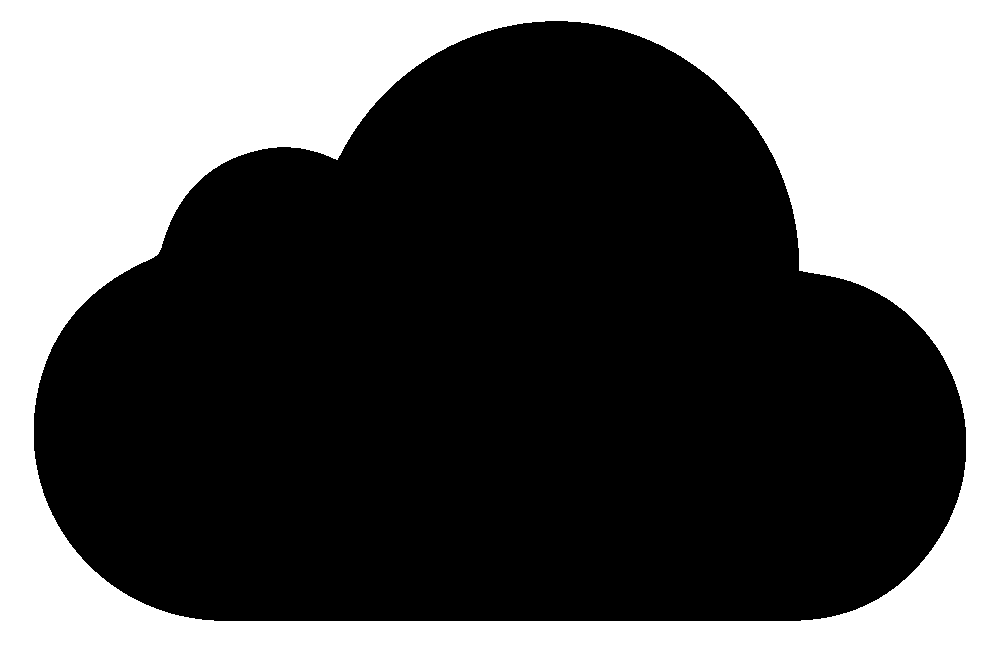

In [115]:
# Tampilkan masking
from google.colab.patches import cv2_imshow

cv2_imshow(cloud_mask)

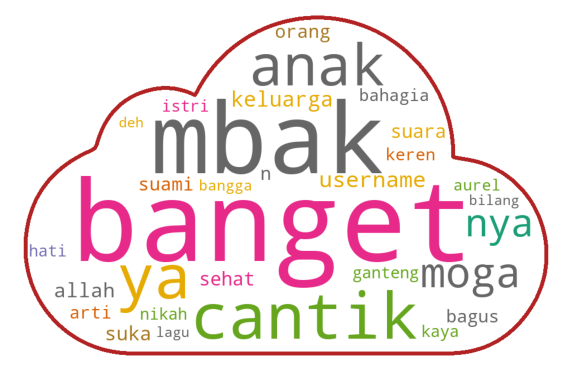

In [116]:
# WordCloud Label Positif

Positive = data[data.Sentiment == 1]
normal_string = []

for t in Positive.clean:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

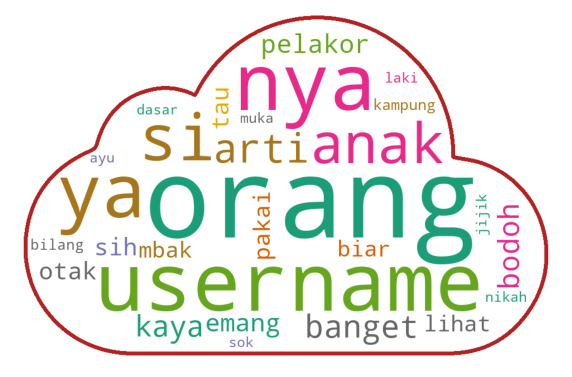

In [117]:
# WordCloud Label Negatif

Negatif = data[data.Sentiment == 0]
normal_string = []

for t in Negatif.clean:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **Deployment**

In [118]:
# load model
model = load('model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [121]:
input_text = input("Masukkan Teks: ")

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('\nHasil Text Preprocessing :', pre_input_text)

if (result==1):
    Sentiment = 'Sentiment Positive'
elif (result==0):
    Sentiment = 'Sentiment Negative'
else:
    Sentiment = 'Nothing'

print('\nHasil prediksi: ', input_text, ' adalah ', Sentiment)

Masukkan Teks: NGGAK SUSAH.. ASAL DENGAN SUKA CITA BELAJAR. ITU SEMUA MASIH GAMPANG DIBANDING KALKULUS

Hasil Text Preprocessing : nggak susah suka cita ajar gampang banding kalkulus

Hasil prediksi:  NGGAK SUSAH.. ASAL DENGAN SUKA CITA BELAJAR. ITU SEMUA MASIH GAMPANG DIBANDING KALKULUS  adalah  Sentiment Positive
